In [ ]:
#default_exp augmentations

# augmentations

>Implmentation heavily inspired by Ignacio Oguiza - oguiza@gmail.com

In [ ]:
#export
import random
from functools import partial
from scipy.interpolate import CubicSpline
from torchtools.data import *
import pywt

In [ ]:
#export
import numpy as np
import torch

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.all import *

In [ ]:
#export
from torchtools.core import *
from torchtools.data import *
from torchtools.datasets import *
from torchtools.dataloader import *
from torchtools.models import *
from torchtools.augmentations import *

#### Helper Function

Copy helper functions, should not be exposed

In [ ]:
def _get_sin(dims=(1,20)): return torch.tensor([np.sin(x) for x in np.arange(dims[1])]).unsqueeze(0)
def _get_log(dims=(1,20)): return torch.tensor([np.log(x+1) for x in np.arange(dims[1])]).unsqueeze(0)

In [ ]:
def _get_sample_tensor(seq_len=20):
    x = np.arange(seq_len)
    return torch.stack([tensor(np.sin(x)), torch.ones(seq_len), torch.rand(seq_len)])


In [ ]:
def _test_aug_func(fn):
    '''
    sanity checks for augmentation functions
    '''
    t1 = torch.randn(10,100)
    t2 = torch.randn(128,10,100)
    assert fn(t1).shape == t1.shape
    assert fn(t2).shape == t2.shape
    assert fn(t1.cuda()).shape == t1.shape
    assert fn(t2.cuda()).shape == t2.shape    
    assert fn(t2.cuda()).device == t2.cuda().device

In [ ]:
def _plot_aug_func(func, magnitude=0.3):
    ts = _get_sample_tensor()
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))
    for i,t in enumerate(ts):
         axes[i].plot(t, label='orig')
    
    
    for i,t in enumerate(func(ts, magnitude=magnitude)):
        axes[i].plot(t, marker='d', linestyle='dashed', label='augmented')
#         plt.plot(t, label='orig')
#         plt.plot(_ynoise_warp(t), label='smooth')
#         plt.plot(_ynoise_normal(t), label='normal')
        plt.legend()
    plt.tight_layout();

In [ ]:
def _test_transform(tf, tsint=True):
    '''
    sanity checks for augmentation transforms
    '''
#     t1 = torch.randn(10,100)
    t1 = TSTensor(torch.randn(128,10,100))
    if tsint: t2=TSIntTensor(torch.randint(-5,5,(128,10,100), dtype=torch.int16))
#     assert fn(t1).shape == t1.shape

    tfms = listify(tf)
    
    for t in tfms:
        assert t(t1).shape == t1.shape
        assert t(t2).shape == t2.shape
        assert t(t1.cuda()).shape == t1.shape    
        assert t(t2.cuda()).shape == t2.shape   
        assert t(t2.cuda()).dtype == t2.dtype

In [ ]:
def _plot_transform(tf, tsint=False, f=_get_sin):
    '''
    sanity checks for augmentation transforms
    '''
    t = f() if not tsint else torch.randint(-5,5,(1,20))
    ts = TSTensor(t) if not tsint else TSIntTensor(t)
    
    tfms = listify(tf)
    n_cols= min(len(tfms), 3)
    n_rows = (len(tfms)-1)//3 +1
    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8,4), squeeze=False)

    
    for tfm, ax in zip(tfms, axes.flatten()):
#         ax = axes[i] if len(tfms)>1 else axes
        ax.plot(t.squeeze(),label='orig')
        ax.plot(tfm(ts).squeeze(), linestyle='dashed',label=f'{tfm.name}')
        ax.legend()
    plt.tight_layout()

### More Augmentations

In [ ]:
from scipy.ndimage import convolve1d

NOTE: scipy/numpy convolve1d/convolve flips the kernel!

In [ ]:
# #tsai reference
# class TSBlur(Transform):
#     "Blurs a sequence applying a filter of type [1, 0..., 1]"
#     order = 90
#     def __init__(self, magnitude=.05, ex=None, **kwargs): self.magnitude, self.ex = magnitude, ex
#     def encodes(self, o: TSTensor):
#         if self.magnitude <= 0: return o
#         if self.magnitude == 3:  filterargs = np.array([1, 0, 1])
#         else: 
#             magnitude = tuple((3, 3 + int(self.magnitude * 4)))
#             n_zeros = int(np.random.choice(np.arange(magnitude[0], magnitude[1] + 1, 2))) - 2
#             filterargs = np.array([1] + [0] * n_zeros + [1])
#         w = filterargs * np.random.rand(len(filterargs))
#         w = w / w.sum()
#         output = o.new(convolve1d(o.cpu(), w, mode='nearest'))
#         if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
#         return output

filterargs [1, random number of zeroes, 1]

In [ ]:
magnitude = tuple((3, 3 + int(0.5 * 4)))

In [ ]:
magnitude

(3, 5)

In [ ]:
n_zeros = int(np.random.choice(np.arange(magnitude[0], magnitude[1] + 1, 2))) - 2

In [ ]:
n_zeros

1

In [ ]:
filterargs = np.array([1] + [0] * n_zeros + [1])

In [ ]:
filterargs

array([1, 0, 1])

In [ ]:
w = filterargs * np.random.rand(len(filterargs))

In [ ]:
w = w/w.sum() 

In [ ]:
w

array([0.18718486, 0.        , 0.81281514])

In [ ]:
t = torch.rand((2,10))

In [ ]:
t.new(convolve1d(t, w, mode='nearest')).shape

torch.Size([2, 10])

In [ ]:
t= _get_sin()

In [ ]:
w

array([0.18718486, 0.        , 0.81281514])

In [ ]:
t

tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
          0.9894,  0.4121, -0.5440, -1.0000, -0.5366,  0.4202,  0.9906,  0.6503,
         -0.2879, -0.9614, -0.7510,  0.1499]])

In [ ]:
convolve1d(t, w, mode='nearest')

array([[ 0.15751062,  0.17020671,  0.71037585,  0.59742874, -0.06479164,
        -0.66744286, -0.6564502 , -0.04192025,  0.611151  ,  0.70233285,
         0.14779311, -0.5426269 , -0.7341583 , -0.2507079 ,  0.46324217,
         0.75128955,  0.34860477, -0.3745856 , -0.7533837 , -0.582359  ]],
      dtype=float32)

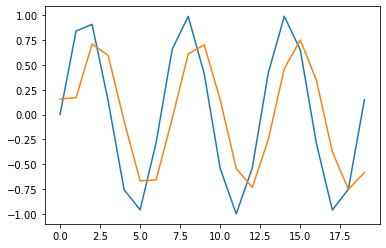

In [ ]:
plt.plot(t[0])
plt.plot(t.new(convolve1d(t,w,mode='nearest'))[0])

In [ ]:
x = np.array([5,2,0,7,9])
w = np.array([1,3])

In [ ]:
convolve1d(x,w, mode='nearest', axis=0)

array([17,  6,  7, 30, 36])

In [ ]:
np.convolve(x,w)

array([ 5, 17,  6,  7, 30, 27])

In [ ]:
t = np.random.randn(1000)
k = np.random.randn(5)

In [ ]:
%%timeit
np.convolve(t,k, 'same')

7.21 µs ± 38.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
%%timeit
convolve1d(t,k)

29.6 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# First a 1-D  Gaussian
t = np.linspace(-10, 10, 30)
bump = np.exp(-0.1*t**2)
bump /= np.trapz(bump) # normalize the integral to 1

# make a 2-D kernel out of it
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]

In [ ]:
t

array([-10.        ,  -9.31034483,  -8.62068966,  -7.93103448,
        -7.24137931,  -6.55172414,  -5.86206897,  -5.17241379,
        -4.48275862,  -3.79310345,  -3.10344828,  -2.4137931 ,
        -1.72413793,  -1.03448276,  -0.34482759,   0.34482759,
         1.03448276,   1.72413793,   2.4137931 ,   3.10344828,
         3.79310345,   4.48275862,   5.17241379,   5.86206897,
         6.55172414,   7.24137931,   7.93103448,   8.62068966,
         9.31034483,  10.        ])

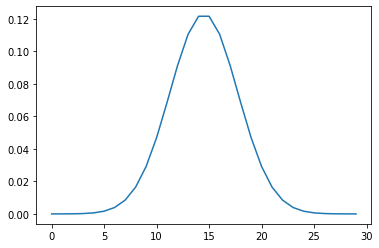

In [ ]:
plt.plot(bump)

In [ ]:
bump.sum()

1.0000055861957333

In [ ]:
kernel

array([[3.12055828e-11, 1.18196079e-10, 4.07063015e-10, 1.27470010e-09,
        3.62946155e-09, 9.39645807e-09, 2.21194316e-08, 4.73447194e-08,
        9.21418511e-08, 1.63053498e-07, 2.62356067e-07, 3.83830873e-07,
        5.10594930e-07, 6.17590908e-07, 6.79224108e-07, 6.79224108e-07,
        6.17590908e-07, 5.10594930e-07, 3.83830873e-07, 2.62356067e-07,
        1.63053498e-07, 9.21418511e-08, 4.73447194e-08, 2.21194316e-08,
        9.39645807e-09, 3.62946155e-09, 1.27470010e-09, 4.07063015e-10,
        1.18196079e-10, 3.12055828e-11],
       [1.18196079e-10, 4.47686339e-10, 1.54181554e-09, 4.82812820e-09,
        1.37471595e-08, 3.55905707e-08, 8.37808447e-08, 1.79325611e-07,
        3.49001831e-07, 6.17590908e-07, 9.93715088e-07, 1.45382012e-06,
        1.93395903e-06, 2.33922322e-06, 2.57266871e-06, 2.57266871e-06,
        2.33922322e-06, 1.93395903e-06, 1.45382012e-06, 9.93715088e-07,
        6.17590908e-07, 3.49001831e-07, 1.79325611e-07, 8.37808447e-08,
        3.55905707e-08,

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
gaussian_filter(np.array([1,0,1]), -2, mode='nearest')

array([1, 0, 1])

In [ ]:
#reference
def _zoom(x, magnitude=.2, rand=False, zoomout=False, window=True, verbose=False):
    '''This is a slow batch tfm
    win_len: zoom into original ts into a section consisting of win_len original data points
    randomly choose one of the seq_len-win_len possible starting points for that section
    within that section, consider seq_len(number of original datapoints) evenly distributed new datapoints 
    and interpolate the respective values with a cubic spline 
    '''
    if magnitude == 0: return x
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only on cpu with CubicSpline

    n_channels, seq_len = x.shape[-2], x.shape[-1]
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    
    window=_rand_steps(seq_len, 1-magnitude, rand=rand, window=window)
    if zoomout: window=np.arange(seq_len-len(window), seq_len)
    pv(window, verbose)
#     x2 = x[..., window]
    fs = [CubicSpline(np.arange(len(window)), x[...,i, window], axis=-1) for i in range(n_channels)]
    output = torch.stack(
        [torch.tensor(fs[i](np.linspace(0,len(window)-1, num=seq_len))) for i in range(n_channels)])
    if len(x.shape)==3: output = output.permute(1,0,2)
#
    return output.to(x_device, x.dtype)


In [ ]:
def _apply_kernel(x, k, sp=True):
    '''
    `np.convolve` pads x with zeros, correpsonds to mode 'constant' with cval=0 in `convolve1d`
    `convolve1d` is slower, but offers more padding options that might make more sense
    `convolved1` pads on the right in the case of a kernel of even size, `np.convolve` on the left
    convolved1d works with higher dimension xs
    '''
    ## on GPU?
    if magnitude == 0: return x
    x_device = x.device ## make sure to put outpout on right device
    #x=x.cpu() ## move to cpu for now for usage with numpy and scipy, but should work on gpu actually
#     output = np.convolve(x,k, mode='same') if not sp else convolve1d(x,k, mode='constant')
#     output = tensor(np.convolve(x,k, mode='same') if not sp else convolve1d(x,k, mode='nearest'))
    output = x.new(convolve1d(x.cpu(),k, mode='nearest'))
#     output = convolve1d(x,k, mode='nearest')

    return output

In [ ]:
t = torch.rand((4,4,10)).cuda()

In [ ]:
%%timeit 
_apply_kernel(t, [0.5, 0, 0.5])

109 µs ± 683 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit 
_apply_kernel(t.cpu(), [0.5, 0, 0.5])

80.6 µs ± 415 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
t_sp = _apply_kernel(t, [0.5, 0, 0.5])

In [ ]:
kt = tensor([1,0,1])

In [ ]:
kt = tensor([0.5, 0., 0.5])[None, None, :].repeat(1,1,1)

In [ ]:
%%timeit
torch.conv1d(t, kt.to(t.device))

80.7 µs ± 465 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
kt.device

device(type='cpu')

In [ ]:
kt=kt.to(t.device)

%timeit torch.cat([torch.conv1d(t[:,i:i+1,:], kt) for i in range(t.shape[1])], dim=1)

373 µs ± 3.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
t_pt = torch.conv1d(t[:, 0:1, :], kt.to(t.device), padding=1)

In [ ]:
t_pt

tensor([[[0.2820, 0.5370, 0.7541, 0.6647, 0.6939, 0.6276, 0.2827, 0.6077,
          0.1476, 0.4269]],

        [[0.4345, 0.5050, 0.5833, 0.3269, 0.2631, 0.2279, 0.5426, 0.4643,
          0.6880, 0.3033]],

        [[0.2051, 0.2833, 0.4173, 0.2826, 0.2342, 0.4235, 0.3813, 0.7870,
          0.5481, 0.4925]],

        [[0.4879, 0.5699, 0.6144, 0.5199, 0.2972, 0.2224, 0.4081, 0.5879,
          0.6161, 0.4270]]], device='cuda:0')

In [ ]:
t_sp

tensor([[[0.6011, 0.5370, 0.7541, 0.6647, 0.6939, 0.6276, 0.2827, 0.6077,
          0.1476, 0.5136],
         [0.5496, 0.3485, 0.7502, 0.3850, 0.4061, 0.4971, 0.4017, 0.4295,
          0.4357, 0.2084],
         [0.2988, 0.5592, 0.3795, 0.6295, 0.3688, 0.5021, 0.1449, 0.6770,
          0.3754, 0.7638],
         [0.6209, 0.3447, 0.5160, 0.2976, 0.3031, 0.6394, 0.2107, 0.5615,
          0.3344, 0.4069]],

        [[0.6794, 0.5050, 0.5833, 0.3269, 0.2631, 0.2279, 0.5426, 0.4643,
          0.6880, 0.5629],
         [0.6838, 0.5771, 0.5199, 0.1102, 0.7753, 0.1607, 0.7539, 0.5085,
          0.4401, 0.5063],
         [0.7778, 0.7833, 0.5761, 0.4860, 0.6694, 0.3855, 0.4649, 0.4829,
          0.3638, 0.5700],
         [0.2708, 0.5418, 0.3062, 0.8142, 0.4142, 0.5391, 0.2039, 0.0767,
          0.1943, 0.1792]],

        [[0.3348, 0.2833, 0.4173, 0.2826, 0.2342, 0.4235, 0.3813, 0.7870,
          0.5481, 0.6813],
         [0.4562, 0.5710, 0.3171, 0.3911, 0.0698, 0.3872, 0.2550, 0.8032,
          0.3

In [ ]:
t[:, 0:1, :].shape

torch.Size([4, 1, 10])

In [ ]:
t_sp.shape

torch.Size([4, 4, 10])

In [ ]:
t_pt.shape

torch.Size([4, 1, 10])

In [ ]:
t_pt

tensor([[[1.2054, 1.7893, 2.3997, 1.9768, 1.7718, 2.2662, 1.0400, 2.2757,
          1.2931, 1.0621]],

        [[1.0454, 2.4072, 1.9855, 1.7374, 2.1219, 1.3132, 1.9652, 1.5322,
          1.6861, 0.9157]],

        [[0.9618, 1.9019, 1.7566, 1.9598, 1.3677, 2.2377, 1.7256, 2.6824,
          1.6171, 1.3037]],

        [[1.4345, 1.7123, 2.4609, 1.7767, 2.0928, 1.1156, 2.6260, 1.7645,
          3.1545, 1.2412]]], device='cuda:0')

In [ ]:
tk = _apply_kernel(t, [0.5, 0, 0.5])

In [ ]:
tk.device

device(type='cuda', index=0)

In [ ]:
t = _get_sin()

In [ ]:
gaussian_filter??

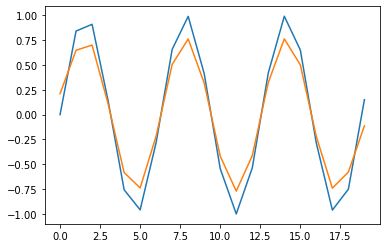

In [ ]:
plt.plot(t[0])
plt.plot(_apply_kernel(t[0], [0.25, 0.5, 0.25]))

In [ ]:
gaussian_filter(t, 3)

array([[ 0.2754134 ,  0.23995756,  0.17934582,  0.11132134,  0.05482545,
         0.02183101,  0.01181277,  0.01343349,  0.01322122,  0.0051369 ,
        -0.006509  , -0.01312284, -0.01152536, -0.00886259, -0.01845479,
        -0.05011639, -0.10272266, -0.16415279, -0.21746586, -0.24809007]],
      dtype=float32)

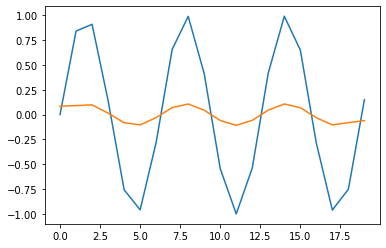

In [ ]:
plt.plot(t[0])
b = 0.1
plt.plot(_apply_kernel(t[0], [b, 0, b], sp=True))

In [ ]:
k = [0.5,0,0,0.5]
t=torch.ones((1,10))
print(t)
print(_apply_kernel(t[0], k))
print(_apply_kernel(t[0], k, sp=True))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
[0.5 0.5 1.  1.  1.  1.  1.  1.  1.  0.5]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
convolve1d(t[0], k, mode='constant')

array([0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 0.5], dtype=float32)

In [ ]:
ns = tuple((3, 3 + int(1.8) * 4))

In [ ]:
ns

(3, 7)

In [ ]:
n_zeros = int(np.random.choice(np.arange(ns[0], ns[1] + 1, 2))) - 2
n_zeros

1

In [ ]:
def _create_blur_filter(x, magnitude=0.1):
    '''
    create a 1d filter for blurring, kernel size 3,5,7
    '''
    filter_len = np.random.choice(np.arange(3, 9, 2))
    filter = ([1, *[0]*(filter_len-2), 1]) 
    filter *= np.random.rand(filter_len)
    filter = np.array(filter)/filter.sum() * (1-magnitude)
    print(filter)
    return filter
    
    

In [ ]:
def _create_smooth_filter(x, magnitude=0.1):
    '''
    create a 1d filter for blurring, kernel size 3,5,7
    '''
    filter_len = np.random.choice(np.arange(3, 9, 2))
    filter = ([1, *[5]*(filter_len-2), 1]) 
    filter *= np.random.rand(filter_len)
    filter = np.array(filter)/filter.sum() * (1-magnitude)
    print(filter)
    return filter
    
    

In [ ]:
def _create_gaussian_filter(x, magnitude=0.1):
    '''
    create a 1d filter for blurring, kernel size 3,5,7
    '''
    filter_len = np.random.choice(np.arange(3, 9, 2))
    filter = ([1, *[0]*(filter_len-2), 1]) 
    filter *= np.random.rand(filter_len)
    filter = np.array(filter)/filter.sum() * (1-magnitude)
    print(filter)
    return filter
    
    

In [ ]:
_create_blur_filter(t), _create_smooth_filter(t), _create_gaussian_filter(t)

[0.42404279 0.         0.         0.         0.47595721]
[0.02266781 0.30035337 0.34276002 0.2112547  0.0229641 ]
[0.29368072 0.         0.         0.         0.60631928]


(array([0.42404279, 0.        , 0.        , 0.        , 0.47595721]),
 array([0.02266781, 0.30035337, 0.34276002, 0.2112547 , 0.0229641 ]),
 array([0.29368072, 0.        , 0.        , 0.        , 0.60631928]))

In [ ]:
_create_gaussian_filter(t)

[0.35754551 0.         0.         0.         0.54245449]


array([0.35754551, 0.        , 0.        , 0.        , 0.54245449])

[0.33347216 0.         0.         0.         0.16652784]
[0.10483314 0.2963906  0.09877626]


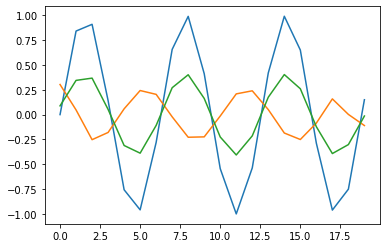

In [ ]:
t = _get_sin()
plt.plot(t[0])
plt.plot(_apply_kernel(t[0], _create_blur_filter(t, magnitude=0.5), sp=True))
plt.plot(_apply_kernel(t[0], _create_smooth_filter(t, magnitude=0.5), sp=True))

In [ ]:
np.random.rand()

0.13398295077188593

In [ ]:
[1, *[0]*5, 1]

[1, 0, 0, 0, 0, 0, 1]

#### End to end

In [ ]:
t

tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
          0.9894,  0.4121, -0.5440, -1.0000, -0.5366,  0.4202,  0.9906,  0.6503,
         -0.2879, -0.9614, -0.7510,  0.1499]])

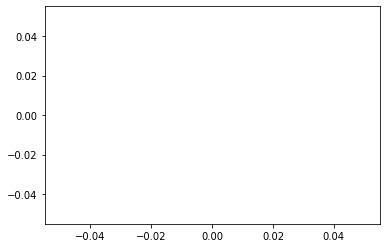

In [ ]:
plt.plot(t[0,0].cpu())

In [ ]:
k = _create_blur_filter(t)

[0.20433869 0.         0.         0.         0.         0.
 0.69566131]


In [ ]:
t_trans = _apply_kernel(t, k, sp=True)

In [ ]:
assert t_trans.shape == t.shape

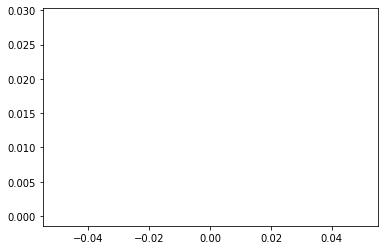

In [ ]:
plt.plot(t[0,0].cpu())
plt.plot(t_trans[0,0].cpu())

In [ ]:
AugTransform??

In [ ]:
#export
# @delegates()
class TSBlur(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('ts_blur', self.verbose)
        return _apply_kernel(x, _create_blur_filter(x, magnitude=self.magnitude), sp=True)

@TSBlur
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

In [ ]:
tsblur = TSBlur()

In [ ]:
t_int = np.random.randint(-2, 5, size=(16,1), dtype='int16')

In [ ]:
t_int_t = TSIntTensor(t_int)

In [ ]:
t_int_t.dtype

torch.int16

In [ ]:
tsblur(t_int_t).dtype

[0.20341515 0.         0.         0.         0.69658485]


torch.int16

In [ ]:
#%inline pylab # <-- add this if you're in an IPython notebook
import pywt
import numpy as np
import seaborn
from statsmodels.robust import mad
 
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    print(x)
    print(y)
    f, ax = plt.subplots()
    plt.plot( x, color="b", alpha=0.5 )
    plt.plot( y, color='r')

In [ ]:
#export
def maddest(d, axis=None): #Mean Absolute Deviation
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In ``soft`` thresholding [1]_, data values with absolute value less than
`param` are replaced with `substitute`. Data values with absolute value
greater or equal to the thresholding value are shrunk toward zero
by `value`.  In other words, the new value is
``data/np.abs(data) * np.maximum(np.abs(data) - value, 0)``.

In ``hard`` thresholding, the data values where their absolute value is
less than the value param are replaced with `substitute`. Data values with
absolute value greater or equal to the thresholding value stay untouched.

In [ ]:
def _wavelet_noise(x, level=2, wavelet='db4', thr_mode='hard', magnitude=1.):
    '''
    basic idea: decompose the ts into a series of coefficients
    truncate coefficients above a certain treshold
    reconstruct ts from truncated coefficients ->smoothend
    '''   
    coeff = pywt.wavedec(x.cpu(), wavelet, mode="per" )
#     sigma = mad( coeff[-level] ) #median absolute deviation
#     sigma = maddest( coeff[-level] )
#     uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = (i*(1+np.random.randn())*magnitude for i in coeff[1:] )
    y = pywt.waverec( coeff, wavelet, mode="per" )
#     print(x)
#     print(y)
    return x.new(y)

In [ ]:
def _wavelet_denoise(x, level=2, wavelet='db4', thr_mode='hard'):
    '''
    corresponds to denoise
    basic idea: decompose the ts into a series of coefficients
    truncate coefficients above a certain treshold
    reconstruct ts from truncated coefficients ->smoothend
    '''   
    seq_len = x.shape[-1]
    coeff = pywt.wavedec(x.cpu(), wavelet, mode="per" )
#     print(len(coeff), coeff[0].shape)
#     sigma = mad( coeff[-level] ) #median absolute deviation
    sigma = (1/0.6745)*maddest( coeff[-level])
    uthresh = sigma * np.sqrt( 2*np.log(seq_len))
    coeff[1:] = ( pywt.threshold(i, value=uthresh, mode=thr_mode ) for i in coeff[1:] )
    y = pywt.waverec( coeff, wavelet, mode="per" )
#     print(x)
#     print(y)
    return x.new(y)

In [ ]:
#export
# @delegates()
class TSWaveNoise(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('waveletNoise', self.verbose)
        return _wavelet_noise(x, magnitude=self.magnitude)

@TSWaveNoise
def encodedes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

In [ ]:
#export
# @delegates()
class TSDenoise(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('TSDenoise', self.verbose)
        return _wavelet_denoise(x)

@TSDenoise
def encodedes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).type(x.dtype), type(x))

In [ ]:
_test_transform(TSWaveNoise())
_test_transform(TSDenoise())
_test_transform(TSBlur())

torch.int16 torch.int16
torch.int16 torch.int16
[0.51253938 0.         0.         0.         0.         0.
 0.38746062]
[0.81700256 0.         0.08299744]
[0.44556647 0.         0.45443353]
[0.64276729 0.         0.25723271]
[0.46681082 0.         0.43318918]
torch.int16 torch.int16
[0.22237618 0.         0.         0.         0.67762382]


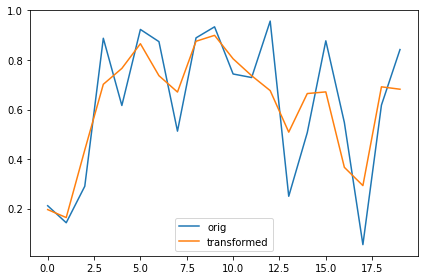

In [ ]:
_plot_transform(TSWaveNoise(magnitude=0.4),  f=lambda: torch.rand((1,20)))

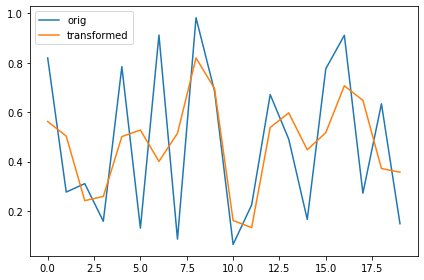

In [ ]:
_plot_transform(TSDenoise(),  f=lambda: torch.rand((1,20)))

[0.27204242 0.         0.         0.         0.62795758]


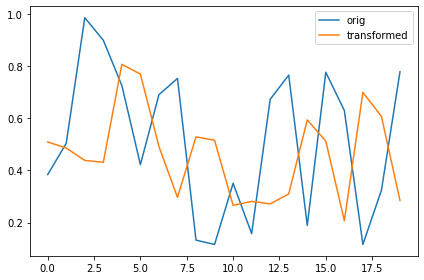

In [ ]:
_plot_transform(TSBlur(), f=lambda: torch.rand((1,20)))

3 (5,)
tensor([0.5297, 0.2735, 0.8319, 0.3143, 0.1887, 0.1547, 0.2590, 0.1716, 0.2639,
        0.1906, 0.1925, 0.6384, 0.8382, 0.0485, 0.3794, 0.1228, 0.6239, 0.3772,
        0.6468, 0.9287])
[0.7179103  0.5226671  0.39881867 0.34636503 0.27478123 0.25367305
 0.21904    0.17088206 0.12634811 0.30254516 0.41959754 0.47750518
 0.55126065 0.43356434 0.3671674  0.35206985 0.3232267  0.48107708
 0.58890307 0.6467047 ]


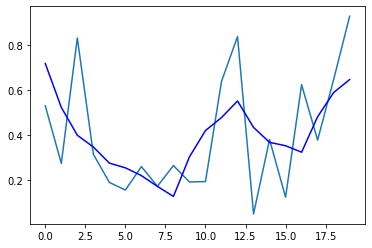

In [ ]:
plt.plot(t[0])
plt.plot(_waveletSmooth(t[0], wavelet='db2', level=2), color='b')
# plt.plot(_waveletSmooth(t[0], level=2, thr_mode='soft'), color='r')
# plt.plot(_waveletSmooth(t[0], level=1))

tensor([0.5297, 0.2735, 0.8319, 0.3143, 0.1887, 0.1547, 0.2590, 0.1716, 0.2639,
        0.1906, 0.1925, 0.6384, 0.8382, 0.0485, 0.3794, 0.1228, 0.6239, 0.3772,
        0.6468, 0.9287])
[ 0.55999315  0.1791147   0.9614943   0.21072403  0.19078854  0.17880324
  0.2767513   0.14162514  0.31856513  0.1640293   0.07410962  0.7202514
  1.0092198  -0.18621626  0.47042137  0.07978439  0.75548357  0.27374578
  0.57371044  1.021708  ]
tensor([0.5297, 0.2735, 0.8319, 0.3143, 0.1887, 0.1547, 0.2590, 0.1716, 0.2639,
        0.1906, 0.1925, 0.6384, 0.8382, 0.0485, 0.3794, 0.1228, 0.6239, 0.3772,
        0.6468, 0.9287])
[0.4831166  0.418404   0.63271534 0.47344255 0.18547127 0.11771094
 0.23183198 0.21753868 0.17990483 0.23148967 0.37436268 0.512611
 0.5754186  0.40899444 0.23965415 0.18884024 0.42172676 0.53611225
 0.75907457 0.78568643]


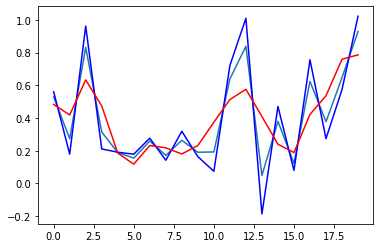

In [ ]:
plt.plot(t[0])
plt.plot(_waveletNoise(t[0], level=2), color='b')
plt.plot(_waveletNoise(t[0], level=2, thr_mode='soft'), color='r')
# plt.plot(_waveletSmooth(t[0], level=1))

In [ ]:
pywt.wavedec(t[0], "db4")

[array([0.929038  , 1.3239906 , 0.03579086, 0.91749805, 1.2901678 ,
        0.20414951, 0.6596863 , 0.6534501 , 0.35354346, 0.3757751 ,
        0.8007171 , 0.9163657 , 0.32656202], dtype=float32),
 array([ 0.0021041 ,  0.03790526,  0.0740702 ,  0.03611742,  0.23870447,
         0.2260763 , -0.256643  , -0.11392312,  0.40455246, -0.5235015 ,
         0.17472246,  0.34015703, -0.5011672 ], dtype=float32)]

In [ ]:
t[0]

tensor([ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
         0.9894,  0.4121, -0.5440, -1.0000, -0.5366,  0.4202,  0.9906,  0.6503,
        -0.2879, -0.9614, -0.7510,  0.1499])

tensor([0.0192, 0.6741, 0.9365, 0.8271, 0.7475, 0.1351, 0.0985, 0.3877, 0.7286,
        0.1994, 0.5380, 0.3278, 0.0468, 0.4958, 0.2661, 0.2332, 0.9632, 0.8991,
        0.1526, 0.3190])
[0.27960628 0.48660052 0.9255268  0.94760466 0.5117363  0.31799403
 0.24075256 0.2555459  0.48285216 0.5179568  0.37526742 0.3292558
 0.30831516 0.25228927 0.19186322 0.3991107  0.8993553  0.8583455
 0.2824456  0.13301753]


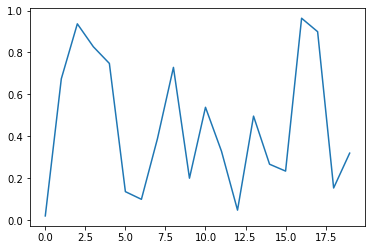

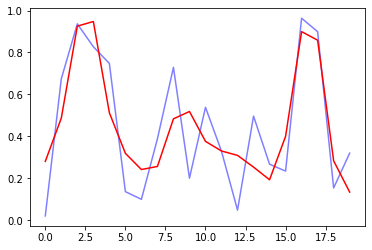

In [ ]:
plt.plot(t[0])
waveletSmooth(t[0])

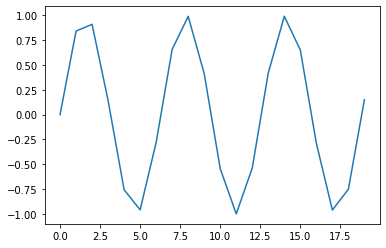

In [ ]:
plt.plot(t[0])